### Import libraries

In [1]:
### Author: Andrea Mastropietro © All rights reserved ###
import os

import torch
from torch_geometric.data import  Data
from torch_geometric.nn import GCNConv, Linear, global_mean_pool
import torch.nn.functional as F

import numpy as np
import random
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import networkx as nx

from pysmiles import read_smiles
from torchdrug import data

from src.utils import create_edge_index, ChemicalDataset
from src.edgeshaper import Edgeshaper

### Set Random Seeds

In [2]:
SEED = 42

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

### Load dataset and instantiate dataset class

Working on device:  cuda


,nonstereo_aromatic_smiles,label
0,Brc1ccc(CNCCN2CCN(Cc3cc4ccccc4[nH]3)CC2)cc1,0
1,Brc1ccc(N2CCN(Cc3ccccc3)CC2)c2cc[nH]c12,0
2,Brc1ccc(NCCN2CCN(CCc3c[nH]c4ccccc34)CC2)cc1,0
3,Brc1ccc(NCCN2CCN(Cc3cc4ccccc4[nH]3)CC2)cc1,0
4,Brc1cccc(N2CCN(Cc3cc4ccccn4n3)CC2)n1,0


Reading molecules


  0%|          | 0/8348 [00:00<?, ?it/s]

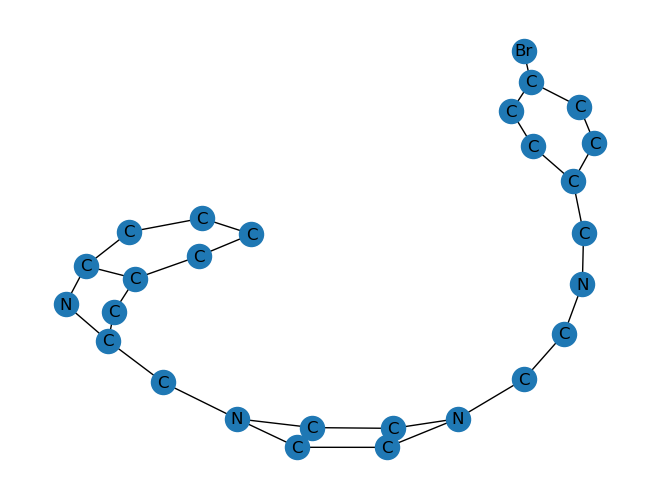

Obtaining features for molecules using TorchDrug


  0%|          | 0/8348 [00:00<?, ?it/s]

c:\Users\Mastro\anaconda3\envs\GNN_XAI_Biomedicine_env\lib\site-packages\torchdrug\data\feature.py:42: UserWarning: Unknown value `Na`
  warnings.warn("Unknown value `%s`" % x)


Creating edge index


  0%|          | 0/8348 [00:00<?, ?it/s]

Creating data list


  0%|          | 0/8348 [00:00<?, ?it/s]

In [3]:
DATA_PATH = "data/compound_data/D2_target_vs_random.csv"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Working on device: ", device)

df_data = pd.read_csv(DATA_PATH, sep = ",")
display(df_data.head())

target_field = "label"
smiles_field = "nonstereo_aromatic_smiles"

smiles = df_data[smiles_field].values.tolist()

mols = []
print("Reading molecules")
for i in tqdm(range(len(smiles))):
    mols.append(read_smiles(smiles[i]))

%matplotlib inline
test_molecule = mols[0]
elements = nx.get_node_attributes(test_molecule, name = "element")
nx.draw(test_molecule, with_labels=True, labels = elements, pos=nx.spring_layout(test_molecule))
plt.show()

mols_torchdrug_format = []
print("Obtaining features for molecules using TorchDrug")
for i in tqdm(range(len(smiles))):
    mols_torchdrug_format.append(data.Molecule.from_smiles(smiles[i], with_hydrogen = False))

edge_index_list = []
print("Creating edge index")
for mol in tqdm(mols):
    edge_index_list.append(create_edge_index(mol))

y = torch.LongTensor(df_data[target_field].values.tolist()).to(device)

data_list = []
print("Creating data list")
for i in tqdm(range(len(mols))):
    data_list.append(Data(x = mols_torchdrug_format[i].node_feature, edge_index = edge_index_list[i], y = y[i], num_nodes = len(mols[i].nodes), smiles = smiles[i]))

dataset = ChemicalDataset(".", data_list = data_list)

### Load model
Need to redefine the model to be able to import it. Better alternative is to define it in an external module (e.g, utils) and import it.

In [4]:
class GCN(torch.nn.Module):
    '''
    4-layer GCN model class.
    '''
    def __init__(self, node_features_dim, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(node_features_dim, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.conv4 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index, batch, edge_weight = None):
        
        x = self.conv1(x.float(), edge_index, edge_weight = edge_weight)
        x = x.relu()
        x = self.conv2(x, edge_index, edge_weight = edge_weight)
        x = x.relu()
        x = self.conv3(x, edge_index, edge_weight = edge_weight)
        x = x.relu()
        x = self.conv4(x, edge_index, edge_weight = edge_weight)
       
        x = global_mean_pool(x, batch)  

        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

In [5]:
NUM_NODE_FEATURES = mols_torchdrug_format[0].node_feature.shape[1]
HIDDEN_CHANNELS = 256
MODEL_PATH = "models/gcn_model.ckpt"
model = GCN(node_features_dim = NUM_NODE_FEATURES, num_classes =dataset.num_classes, hidden_channels=HIDDEN_CHANNELS).to(device)
model.load_state_dict(torch.load(MODEL_PATH))
model.to(device)

GCN(
  (conv1): GCNConv(67, 256)
  (conv2): GCNConv(256, 256)
  (conv3): GCNConv(256, 256)
  (conv4): GCNConv(256, 256)
  (lin): Linear(256, 2, bias=True)
)

### Select molecules to explain from the test set
Having set the random seed, the data split should be the same. However, it is good and better practice to save the train, validation, and test indices to avoid errors.

In [6]:
lengths = [int(0.8 * len(dataset)), int(0.1 * len(dataset))]
lengths += [len(dataset) - sum(lengths)]

dataset = dataset.shuffle() 
train_data = dataset[:lengths[0]]
val_data = dataset[lengths[0]+1:lengths[0] + lengths[1]+1]
test_data = dataset[lengths[0] + lengths[1] + 1: ]

In [7]:
molecules_to_explain = []
NUMBER_OF_MOLECULES_TO_EXPLAIN = 20
TARGET_CLASS = 0 #active
rng = np.random.default_rng(SEED)
#create random sequence of len test_data
seq = rng.permutation(len(test_data))

for i in seq:
    if test_data[i].y == TARGET_CLASS:
        test_cpd = test_data[i].to(device)
        batch = torch.zeros(test_cpd.x.shape[0], dtype=int, device=test_cpd.x.device)
        out = model(test_cpd.x, test_cpd.edge_index, batch=batch)
        out_prob = F.softmax(out, dim = 1)
        predicted_class = torch.argmax(out_prob[0]).item()

        if predicted_class == TARGET_CLASS:
            molecules_to_explain.append(test_data[i])
    if len(molecules_to_explain) == NUMBER_OF_MOLECULES_TO_EXPLAIN:
        break

In [8]:
display(molecules_to_explain)
display(len(molecules_to_explain))

[Data(x=[34, 67], edge_index=[2, 72], y=[1], smiles='CCc1cn(CCCCN2CCN(c3cc(C(F)(F)F)nc(C(C)(C)C)n3)CC2)c(=O)[nH]c1=O', num_nodes=34),
 Data(x=[29, 67], edge_index=[2, 66], y=[1], smiles='CN1CCC(c2cn(-c3ccc(F)cc3)c3ccc(-c4ccncc4)cc23)CC1', num_nodes=29),
 Data(x=[29, 67], edge_index=[2, 64], y=[1], smiles='CCS(=O)(=O)NC1CCC(CCN2CCN(c3nccc4occc34)CC2)CC1', num_nodes=29),
 Data(x=[24, 67], edge_index=[2, 52], y=[1], smiles='Cc1cc(OCCCN2CCN(c3ccccc3)CC2)ccc1Cl', num_nodes=24),
 Data(x=[20, 67], edge_index=[2, 44], y=[1], smiles='CCCN(CCC)C1Cc2cccc3nc(O)n(c23)C1', num_nodes=20),
 Data(x=[33, 67], edge_index=[2, 74], y=[1], smiles='O=C1CCc2ccc(OCCCCN3CCN(c4cc(F)cc5ccccc45)CC3)nc2N1', num_nodes=33),
 Data(x=[38, 67], edge_index=[2, 82], y=[1], smiles='COc1ccc(S(=O)(=O)NC2CCC(N3CCC(c4ccccc4OCC(F)(F)F)CC3)CC2)cc1OC', num_nodes=38),
 Data(x=[26, 67], edge_index=[2, 58], y=[1], smiles='COc1cccc(CN2CC=C(c3c[nH]c4ccc(OC)cc34)CC2)c1', num_nodes=26),
 Data(x=[15, 67], edge_index=[2, 30], y=[1], smile

20

### Explaining predictions using EdgeSHAPer
We use the Edgeshaper module to generate explanations saving summary files and feature mapping images for all explained compounds.

In [9]:
SAVE_FOLDER_PATH = "results/compound_activity_explanations_edgeshaper/"
fidelity_list = []
infidelity_list = []

print("Explaining compounds...")
for test_cpd in tqdm(molecules_to_explain):
    print("Explaining test compound: ", test_cpd.smiles)
    test_cpd = test_cpd.to(device)

    edgeshaper_explainer = Edgeshaper(model, test_cpd.x, test_cpd.edge_index, device = device)
    phi_edges = edgeshaper_explainer.explain(M = 100, target_class = TARGET_CLASS, seed = SEED)

    SAVE_FOLDER_PATH_COMPOUND = SAVE_FOLDER_PATH + test_cpd.smiles
    if not os.path.exists(SAVE_FOLDER_PATH_COMPOUND):
        os.makedirs(SAVE_FOLDER_PATH_COMPOUND)
    INFO_EXPLANATIONS = SAVE_FOLDER_PATH_COMPOUND + "/info_explanations.txt"

    with open(INFO_EXPLANATIONS, "w+") as saveFile:
        saveFile.write("Explaining class " + str(TARGET_CLASS) + " for compound: " + test_cpd.smiles + "\n\n")

        saveFile.write("Shapley values for edges:\n")
        for i in range(len(phi_edges)):
            saveFile.write("(" + str(test_cpd.edge_index[0][i].item()) + "," + str(test_cpd.edge_index[1][i].item()) + "): " + str(phi_edges[i]) + "\n")

        saveFile.write("\nSum of Shapley values: " + str(sum(phi_edges)) + "\n\n")

    #compute minimal informative sets (Pertinent Positive Set and Minimal Top-k Set)
    print("Computing minimal informative sets")
    pert_pos, inf = edgeshaper_explainer.compute_pertinent_positive_set(verbose=True)
    min_top_k, fid = edgeshaper_explainer.compute_minimal_top_k_set(verbose=True)

    fidelity_list.append(fid)
    infidelity_list.append(inf)

    with open(INFO_EXPLANATIONS, "a+") as saveFile:
        saveFile.write("Minimal top-k set edge index:\n")
        saveFile.write(str(min_top_k.tolist()) + "\n\n")
        saveFile.write("FID+: " + str(fid) + "\n\n")

        saveFile.write("Pertinent positive set edge index:\n")
        saveFile.write(str(pert_pos.tolist()) + "\n\n")
        saveFile.write("FID-: " + str(inf) + "\n\n")
    
    #visualize the explanation - feature mapping
    edgeshaper_explainer.visualize_molecule_explanations(test_cpd.smiles, save_path = SAVE_FOLDER_PATH_COMPOUND, pertinent_positive=True, minimal_top_k=True)

   
print("Finished explaining.")

Explaining compounds...


  0%|          | 0/20 [00:00<?, ?it/s]

Explaining test compound:  CCc1cn(CCCCN2CCN(c3cc(C(F)(F)F)nc(C(C)(C)C)n3)CC2)c(=O)[nH]c1=O


100%|██████████| 72/72 [01:15<00:00,  1.06s/it]


Computing minimal informative sets
FID- using pertinent positive set:  0.2407679557800293
FID+ using minimal top-k set:  0.8254188597202301
Explaining test compound:  CN1CCC(c2cn(-c3ccc(F)cc3)c3ccc(-c4ccncc4)cc23)CC1


100%|██████████| 66/66 [01:06<00:00,  1.00s/it]


Computing minimal informative sets
FID- using pertinent positive set:  -0.00024759769439697266
FID+ using minimal top-k set:  0.9859941639006138
Explaining test compound:  CCS(=O)(=O)NC1CCC(CCN2CCN(c3nccc4occc34)CC2)CC1


100%|██████████| 64/64 [01:07<00:00,  1.06s/it]


Computing minimal informative sets
FID- using pertinent positive set:  0.0009794235229492188
FID+ using minimal top-k set:  1.0
Explaining test compound:  Cc1cc(OCCCN2CCN(c3ccccc3)CC2)ccc1Cl


100%|██████████| 52/52 [00:51<00:00,  1.01it/s]


Computing minimal informative sets
FID- using pertinent positive set:  0.021588027477264404
FID+ using minimal top-k set:  0.9999999999989836
Explaining test compound:  CCCN(CCC)C1Cc2cccc3nc(O)n(c23)C1


100%|██████████| 44/44 [00:42<00:00,  1.04it/s]


Computing minimal informative sets
FID- using pertinent positive set:  0.0016418099403381348
FID+ using minimal top-k set:  0.7897291630506516
Explaining test compound:  O=C1CCc2ccc(OCCCCN3CCN(c4cc(F)cc5ccccc45)CC3)nc2N1


100%|██████████| 74/74 [01:20<00:00,  1.08s/it]


Computing minimal informative sets
FID- using pertinent positive set:  0.020764648914337158
FID+ using minimal top-k set:  0.9949625139124691
Explaining test compound:  COc1ccc(S(=O)(=O)NC2CCC(N3CCC(c4ccccc4OCC(F)(F)F)CC3)CC2)cc1OC


100%|██████████| 82/82 [01:30<00:00,  1.11s/it]


Computing minimal informative sets
FID- using pertinent positive set:  -9.131431579589844e-05
FID+ using minimal top-k set:  0.5789193511009216
Explaining test compound:  COc1cccc(CN2CC=C(c3c[nH]c4ccc(OC)cc34)CC2)c1


100%|██████████| 58/58 [00:59<00:00,  1.02s/it]


Computing minimal informative sets
FID- using pertinent positive set:  0.018032550811767578
FID+ using minimal top-k set:  0.9928765422664583
Explaining test compound:  C#CC1=CCC(N(CCC)CCC)CC1


100%|██████████| 30/30 [00:28<00:00,  1.06it/s]


Computing minimal informative sets
FID- using pertinent positive set:  0.09944450855255127
FID+ using minimal top-k set:  0.9999720390969742
Explaining test compound:  CN1CCN2c3ccccc3Cc3ccccc3C2C1


100%|██████████| 46/46 [00:47<00:00,  1.02s/it]


Computing minimal informative sets
FID- using pertinent positive set:  1.3828277587890625e-05
FID+ using minimal top-k set:  0.9908388089388609
Explaining test compound:  c1ccc(C2CCN(Cc3c[nH]c4ccccc34)CC2)cc1


100%|██████████| 50/50 [00:48<00:00,  1.02it/s]


Computing minimal informative sets
FID- using pertinent positive set:  0.001383662223815918
FID+ using minimal top-k set:  0.945207878947258
Explaining test compound:  CC(C)(C)c1nc(N2CCN(CCCCN3C(=O)CC(=O)c4ccccc43)CC2)cc(C(F)(F)F)n1


100%|██████████| 78/78 [01:20<00:00,  1.03s/it]


Computing minimal informative sets
FID- using pertinent positive set:  0.009486913681030273
FID+ using minimal top-k set:  0.7794846743345261
Explaining test compound:  FC(CCNCc1ccc2c(c1)Cc1ccccc1-2)CN1CCN(c2cccc(Cl)c2Cl)CC1


100%|██████████| 76/76 [01:18<00:00,  1.03s/it]


Computing minimal informative sets
FID- using pertinent positive set:  0.04873526096343994
FID+ using minimal top-k set:  1.0
Explaining test compound:  O=C1COc2c(N3CCN(CCCCOc4ccn5ncc(C=NO)c5c4)CC3)ccc(O)c2N1


100%|██████████| 78/78 [01:20<00:00,  1.03s/it]


Computing minimal informative sets
FID- using pertinent positive set:  0.10745429992675781
FID+ using minimal top-k set:  0.9993491662899032
Explaining test compound:  Cn1c(SCCCN2CC3CC3(c3ccc(C(F)(F)F)cc3)C2)nnc1-c1ccnnc1


100%|██████████| 72/72 [01:11<00:00,  1.00it/s]


Computing minimal informative sets
FID- using pertinent positive set:  0.4993642568588257
FID+ using minimal top-k set:  0.9877104982733727
Explaining test compound:  CN1CCC(c2nnc(SCCCN3CCC4(CC4c4ccc(C(F)(F)F)cc4)C3)n2C)CC1=O


100%|██████████| 78/78 [01:19<00:00,  1.02s/it]


Computing minimal informative sets
FID- using pertinent positive set:  0.37139439582824707
FID+ using minimal top-k set:  0.9945977060124278
Explaining test compound:  COc1ccccc1N1CCN(CCCCCCNS(=O)(=O)c2ccc3ccccc3c2)CC1


100%|██████████| 74/74 [01:12<00:00,  1.03it/s]


Computing minimal informative sets
FID- using pertinent positive set:  0.024522066116333008
FID+ using minimal top-k set:  0.8406211584806442
Explaining test compound:  O=C(NCCCCN1CCCN(C(c2ccccc2)c2ccccc2)CC1)c1cc2ccccc2s1


100%|██████████| 80/80 [01:22<00:00,  1.03s/it]


Computing minimal informative sets
FID- using pertinent positive set:  0.3383541703224182
FID+ using minimal top-k set:  0.8446426689624786
Explaining test compound:  COc1ccc(C2(C)NC(=O)N(CC(O)CN3CCN(c4ccccc4C#N)CC3)C2=O)cc1


100%|██████████| 74/74 [01:23<00:00,  1.14s/it]


Computing minimal informative sets
FID- using pertinent positive set:  0.05385708808898926
FID+ using minimal top-k set:  0.9994296202785335
Explaining test compound:  O=C(CC1COCCO1)NC1CCC(CCN2CCC(c3cccc4c3OCO4)CC2)CC1


100%|██████████| 74/74 [01:23<00:00,  1.13s/it]


Computing minimal informative sets
FID- using pertinent positive set:  0.01963287591934204
FID+ using minimal top-k set:  0.9995051960868295
Finished explaining.


<Figure size 640x480 with 0 Axes>

In [11]:
print("Average FID+: ", sum(fidelity_list)/len(fidelity_list))
print("Average FID-: ", sum(infidelity_list)/len(infidelity_list))

Average FID+:  0.9274630004826069
Average FID-:  0.09385394155979157
